In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, RNN
from keras.layers import Dropout

input data of ABBANK

In [4]:
df = pd.read_csv('/content/Data_RENATA.csv')
df.head()

,date,last_traded_price,high,low,opening_price,closing_price,trade,value_mn,volume,month,day_of_month,day_of_year,day_of_week,difference
0,2012-12-30,740.0,758.0,736.2,758.0,739.5,49,3.1077,4200,12,30,365,6,21.8
1,2012-12-27,740.0,749.0,738.2,749.0,741.0,21,3.1504,4250,12,27,362,3,10.8
2,2012-12-26,739.0,743.0,738.0,743.0,740.6,22,2.9637,4000,12,26,361,2,5.0
3,2012-12-24,742.0,749.0,735.3,749.0,741.3,28,3.8668,5200,12,24,359,0,13.7
4,2012-12-23,736.0,749.0,735.5,740.0,739.1,47,4.4388,6000,12,23,358,6,13.5


In [5]:

df.index  = df['date']
df

,date,last_traded_price,high,low,opening_price,closing_price,trade,value_mn,volume,month,day_of_month,day_of_year,day_of_week,difference
date,,,,,,,,,,,,,,
2012-12-30,2012-12-30,740.0,758.0,736.2,758.0,739.5,49,3.1077,4200,12,30,365,6,21.8
2012-12-27,2012-12-27,740.0,749.0,738.2,749.0,741.0,21,3.1504,4250,12,27,362,3,10.8
2012-12-26,2012-12-26,739.0,743.0,738.0,743.0,740.6,22,2.9637,4000,12,26,361,2,5.0
2012-12-24,2012-12-24,742.0,749.0,735.3,749.0,741.3,28,3.8668,5200,12,24,359,0,13.7
2012-12-23,2012-12-23,736.0,749.0,735.5,740.0,739.1,47,4.4388,6000,12,23,358,6,13.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-07,2019-01-07,1144.9,1146.9,1140.4,1142.0,1143.7,243,7.8810,6901,1,7,7,0,6.5
2019-01-06,2019-01-06,1146.0,1148.1,1136.5,1141.0,1141.9,357,17.6450,15436,1,6,6,6,11.6
2019-01-03,2019-01-03,1141.9,1142.2,1130.3,1130.4,1141.9,213,10.4040,9156,1,3,3,3,11.9


Take closing_price for prediction

In [6]:
values = DataFrame(df['closing_price'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.949256  0.899997  0.762136  0.978273
t+1   0.949256  1.000000  0.939726  0.780402  0.939759
t+5   0.899997  0.939726  1.000000  0.812553  0.889957
t+10  0.762136  0.780402  0.812553  1.000000  0.757060
t+30  0.978273  0.939759  0.889957  0.757060  1.000000


Split train and test data

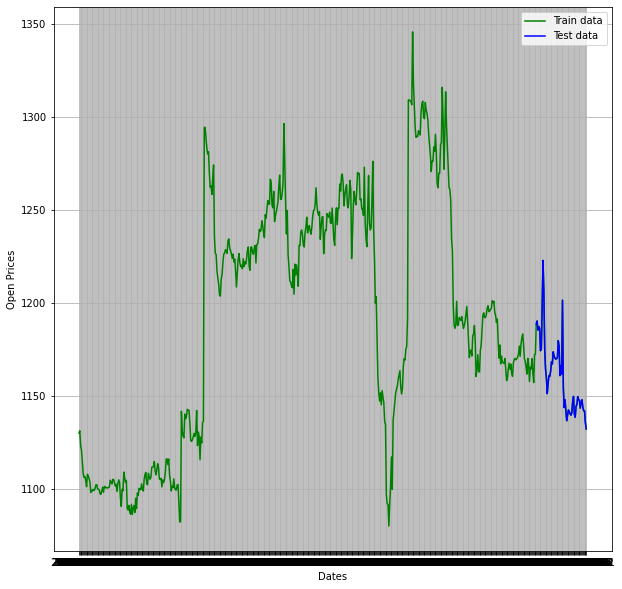

In [7]:
train_data, test_data = df[0:-60], df[-60:]
plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(df['closing_price'].tail(600), 'green', label='Train data')
plt.plot(test_data['closing_price'], 'blue', label='Test data')
plt.legend()

Show the closing_price column data

In [8]:
df['closing_price']

date
2012-12-30     739.5
2012-12-27     741.0
2012-12-26     740.6
2012-12-24     741.3
2012-12-23     739.1
               ...  
2019-01-07    1143.7
2019-01-06    1141.9
2019-01-03    1141.9
2019-01-02    1135.6
2019-01-01    1132.1
Name: closing_price, Length: 1926, dtype: float64

We take 60 days data to test our models

In [9]:
test_data.shape

(60, 14)

In [10]:
train_data.closing_price.tail(30) 

date
2019-05-15    1167.0
2019-05-14    1162.0
2019-05-13    1160.4
2019-05-12    1167.6
2019-05-09    1169.5
2019-05-08    1170.1
2019-05-07    1169.3
2019-05-06    1169.9
2019-05-05    1170.7
2019-05-02    1172.3
2019-04-30    1176.7
2019-04-29    1171.2
2019-04-28    1177.8
2019-04-25    1181.1
2019-04-24    1183.2
2019-04-23    1177.4
2019-04-21    1169.9
2019-04-18    1168.5
2019-04-17    1165.3
2019-04-16    1161.6
2019-04-15    1170.1
2019-04-11    1166.8
2019-04-10    1157.6
2019-04-09    1165.3
2019-04-08    1164.4
2019-04-07    1169.9
2019-04-04    1162.4
2019-04-03    1157.0
2019-04-02    1172.2
2019-04-01    1172.4
Name: closing_price, dtype: float64

MSE: 11657.312099739827
MAE: 106.11439771547312
RMSE: 107.96903305920559


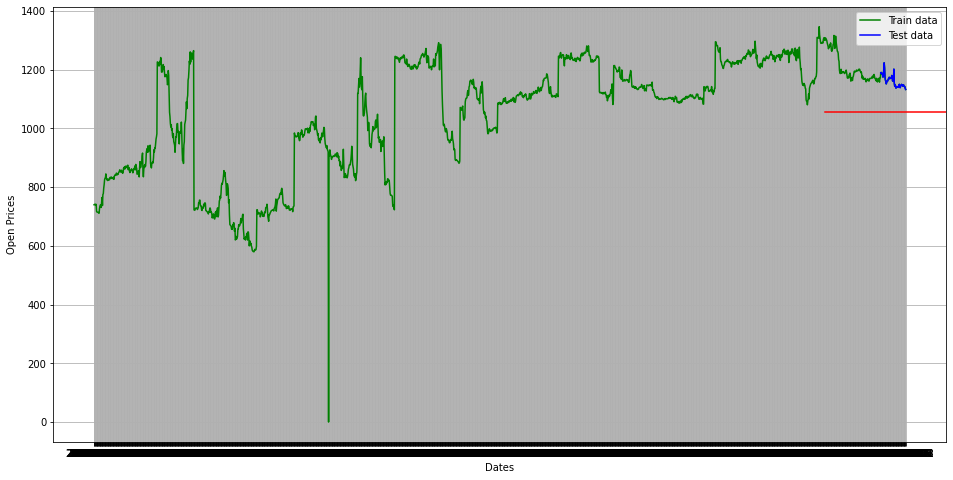

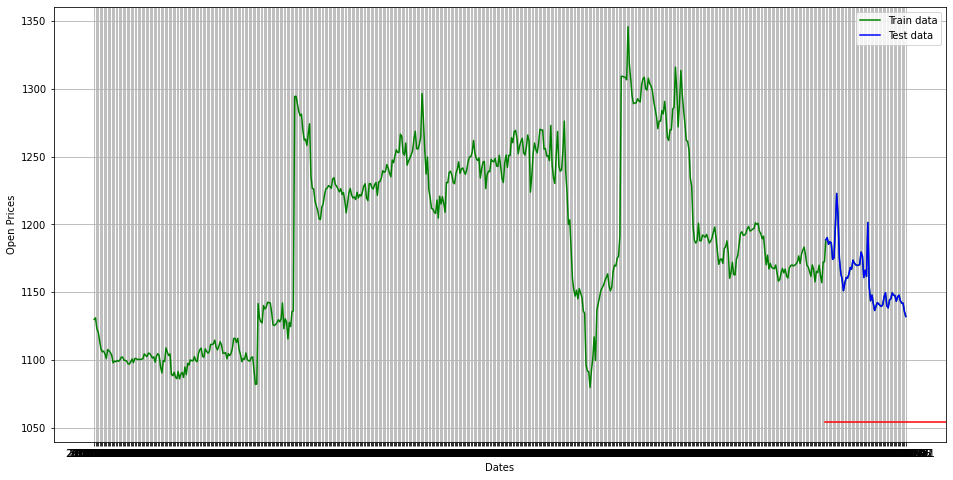

In [11]:
mean_value = df['closing_price'].mean() # calculation of mean price

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(df['closing_price'], 'green', label='Train data')
plt.plot(test_data['closing_price'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(df['closing_price'].tail(600), 'green', label='Train data')
plt.plot(test_data['closing_price'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

print('MSE: '+str(mean_squared_error(test_data['closing_price'], np.full(len(test_data), mean_value))))
print('MAE: '+str(mean_absolute_error(test_data['closing_price'], np.full(len(test_data), mean_value))))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['closing_price'], np.full(len(test_data), mean_value)))))

Train data for ARIMA model

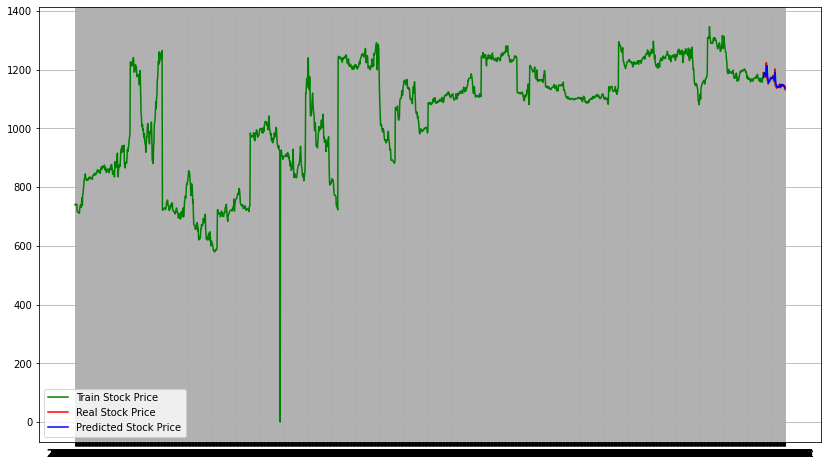

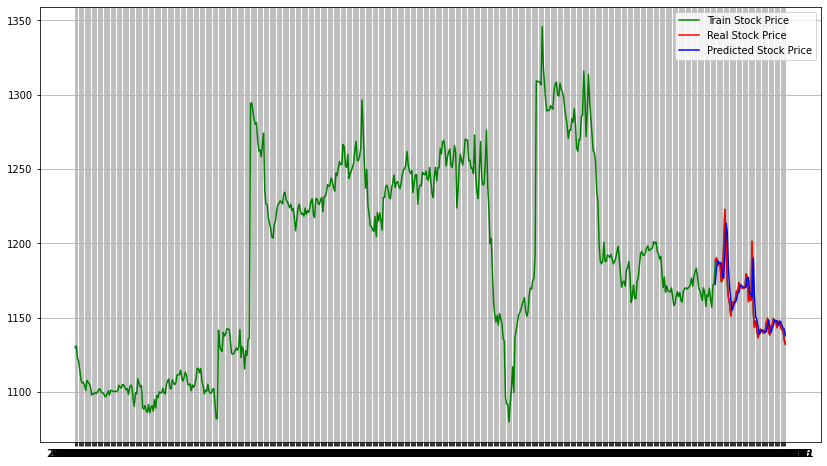

MSE: 132.136508828026
MAE: 7.021693555071761
RMSE: 11.495064542142684


In [12]:
train_arima = train_data['closing_price']
test_arima = test_data['closing_price']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    
plt.figure(figsize=(14,8))
plt.plot(df.index, df['closing_price'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(df.index[-600:], df['closing_price'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

In [13]:
test_data.reset_index(drop=True, inplace=True)

Predicted result for ARIMA model

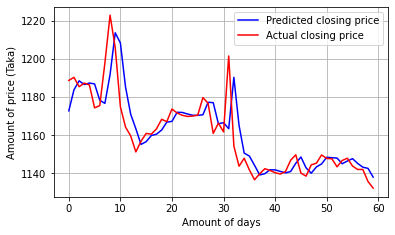

In [14]:
#y_test = df.iloc[int(7200): ,0:1].values
plt.figure(figsize=(6,3.5))
#plt.suptitle('Sine and cosine waves', fontsize=13)
plt.plot(predictions, color='blue', label='Predicted closing price')
plt.plot(test_data['closing_price'], color ='red', label='Actual closing price')
plt.xlabel('Amount of days', fontsize=10)
plt.ylabel('Amount of price (Taka)', fontsize=10)
#plt.xticks(rotation=0,fontsize=12)
#plt.yticks(rotation=0,fontsize=12)
plt.grid(True)
#plt.savefig('ARIMA_Close_Price.jpeg')
plt.legend()
plt.show()

Pre-process data for Prophet model

In [15]:
ph_df_train = train_data.drop(['last_traded_price', 'high', 'low','opening_price',
                               'trade','value_mn','volume','month','day_of_month',
                               'day_of_year','day_of_week','difference'], axis=1)
ph_df_train['date'] = ph_df_train.index
ph_df_train.rename(columns={'closing_price': 'y', 'date': 'ds'}, inplace=True)

prop = Prophet(changepoint_prior_scale=0.1)
prop.fit(ph_df_train)
# Create Future dates
future_prices = prop.make_future_dataframe(periods=73)

# Predict Prices
forecast = prop.predict(future_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
forecast['yhat']

0       1095.549539
1       1095.275785
2       1097.743046
3       1099.596106
4       1102.607968
           ...     
1933    1241.676088
1934    1238.355336
1935    1238.078626
1936    1237.550121
1937    1238.593146
Name: yhat, Length: 1938, dtype: float64

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


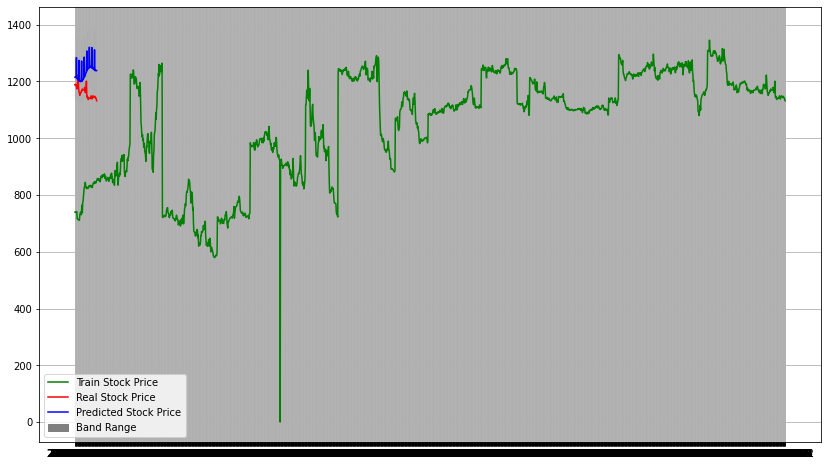

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


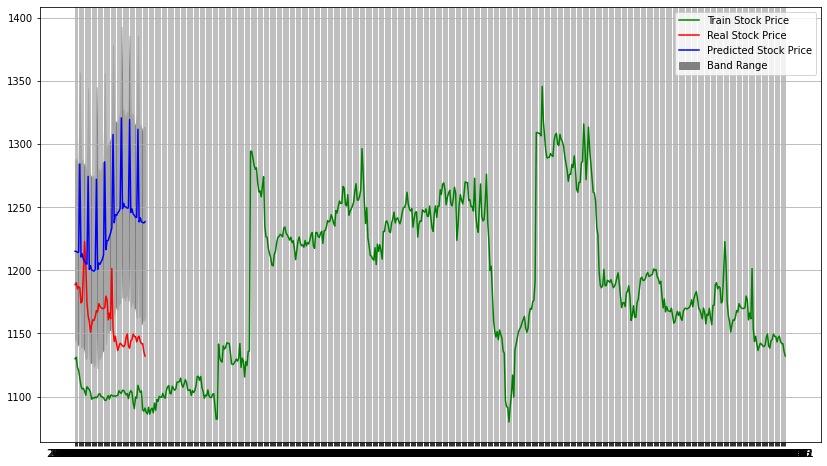

MSE: 7553.090625441361
MAE: 76.05652512009507
RMSE: 86.90851871618433


In [17]:
plt.figure(figsize=(14,8))
plt.plot(df.index, df['closing_price'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['closing_price'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-60:], color = 'blue', label = 'Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-60:], forecast['yhat_upper'][-60:], color='grey', label="Band Range")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(df.index[-600:], df['closing_price'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['closing_price'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-60:], color = 'blue', label = 'Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-60:], forecast['yhat_upper'][-60:], color='grey', label="Band Range")
plt.legend()
plt.grid(True)
plt.show()
print('MSE: '+str(mean_squared_error(test_data['closing_price'], forecast['yhat'][-60:])))
print('MAE: '+str(mean_absolute_error(test_data['closing_price'], forecast['yhat'][-60:])))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['closing_price'], forecast['yhat'][-60:]))))

In [18]:
train = train_data.iloc[:, 1:2].values # selecting open prices
# Feature Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 
# Train dataset
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

LSTM model training

In [19]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
#model.add(Dropout(0.2))

model.add(LSTM(units = 50))
#model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 16)

Epoch 1/100
117/117 [==============================] - 9s 8ms/step - loss: 0.0410
Epoch 2/100
117/117 [==============================] - 1s 8ms/step - loss: 0.0051
Epoch 3/100
117/117 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 4/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0053
Epoch 5/100
117/117 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 6/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0051
Epoch 7/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0049
Epoch 8/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0050
Epoch 9/100
117/117 [==============================] - 1s 8ms/step - loss: 0.0052
Epoch 10/100
117/117 [==============================] - 1s 8ms/step - loss: 0.0049
Epoch 11/100
117/117 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 12/100
117/117 [==============================] - 1s 8ms/step - loss: 0.0049
Epoch 13/100


In [20]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,1:2].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['closing_price'], test_data['closing_price']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

Predicted result for LSTM model

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


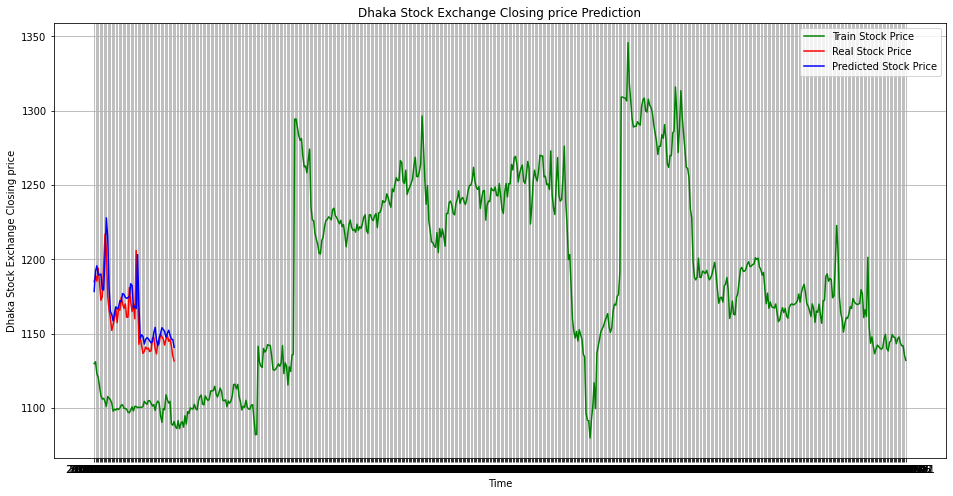

MSE: 143.54547811194251
MAE: 8.947321777343742
RMSE: 11.981046620055466


In [21]:
plt.figure(figsize=(16,8))
plt.plot(df.index[-600:], df['closing_price'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Dhaka Stock Exchange Closing price Prediction')
plt.xlabel('Time')
plt.ylabel('Dhaka Stock Exchange Closing price')
plt.legend()
plt.grid(True)
#plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

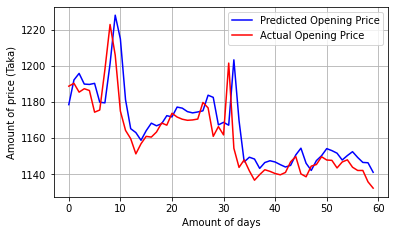

In [22]:
test_data.reset_index(drop=True, inplace=True)
#y_test = df.iloc[int(7200): ,0:1].values
plt.figure(figsize=(6,3.5))
#plt.suptitle('Sine and cosine waves', fontsize=13)
plt.plot(predicted_stock_price, color='blue', label='Predicted Opening Price')
plt.plot(test_data['closing_price'], color ='red', label='Actual Opening Price')
plt.xlabel('Amount of days', fontsize=10)
plt.ylabel('Amount of price (Taka)', fontsize=10)
#plt.xticks(rotation=0,fontsize=12)
#plt.yticks(rotation=0,fontsize=12)
plt.grid(True)
#plt.savefig('LSTM_opening_price.jpeg')
plt.legend()
plt.show()

Training data by GRU model

In [23]:
model = Sequential()

# Adding the first GRU layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) GRU layer ahead in the network.
model.add(GRU(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(GRU(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 200, batch_size = 16)

Epoch 1/200
117/117 [==============================] - 5s 12ms/step - loss: 0.0375
Epoch 2/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0125
Epoch 3/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0106
Epoch 4/200
117/117 [==============================] - 1s 11ms/step - loss: 0.0108
Epoch 5/200
117/117 [==============================] - 1s 11ms/step - loss: 0.0093
Epoch 6/200
117/117 [==============================] - 1s 11ms/step - loss: 0.0091
Epoch 7/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0092
Epoch 8/200
117/117 [==============================] - 1s 11ms/step - loss: 0.0094
Epoch 9/200
117/117 [==============================] - 1s 10ms/step - loss: 0.0088
Epoch 10/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0087
Epoch 11/200
117/117 [==============================] - 1s 11ms/step - loss: 0.0080
Epoch 12/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0084
E

In [24]:
# this will be used later while comparing and visualization
real_stock_price_GRU = test_data.iloc[:,1:2].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['closing_price'], test_data['closing_price']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price_GRU = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price_GRU = scaler.inverse_transform(predicted_stock_price_GRU)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


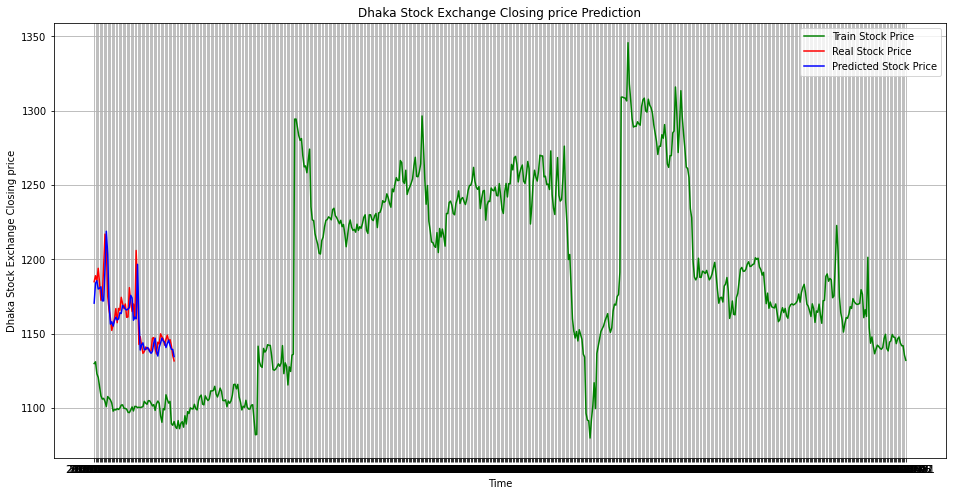

MSE: 108.10336143050593
MAE: 6.732738444010416
RMSE: 10.39727663527839


In [25]:
plt.figure(figsize=(16,8))
plt.plot(df.index[-600:], df['closing_price'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price_GRU, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price_GRU, color = 'blue', label = 'Predicted Stock Price')
plt.title('Dhaka Stock Exchange Closing price Prediction')
plt.xlabel('Time')
plt.ylabel('Dhaka Stock Exchange Closing price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price_GRU, predicted_stock_price_GRU)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price_GRU, predicted_stock_price_GRU)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price_GRU, predicted_stock_price_GRU))
print('RMSE: '+str(rmse))

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


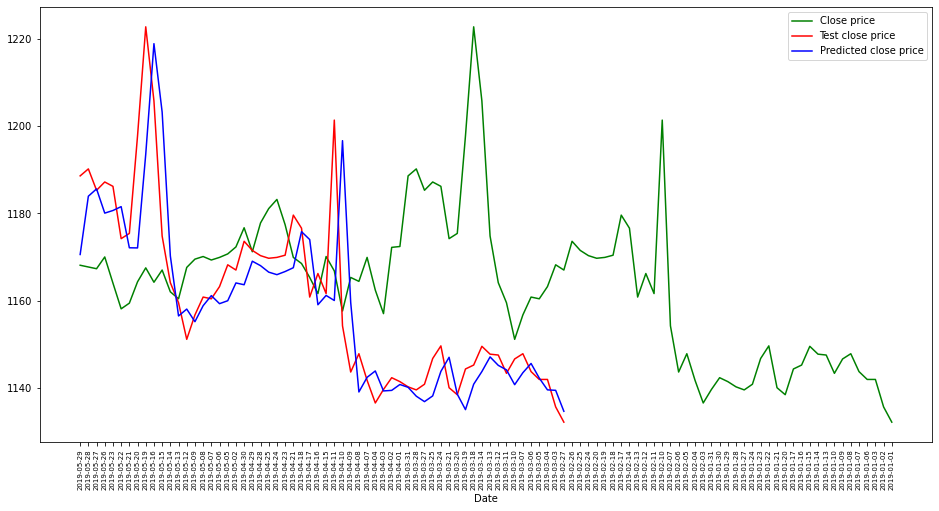

In [26]:
plt.figure(figsize=(16,8))
#print('Lag: %s' % model_fit.k_ar)
plt.plot(df.index[-100:], df['closing_price'].tail(100), color='green', label='Close price')
plt.plot(test_data.index, test_data['closing_price'], color='red', label='Test close price')
plt.plot(test_data.index, predicted_stock_price_GRU, color='blue', label='Predicted close price')
plt.xlabel('Date', fontsize=10)
plt.xticks(rotation=90,fontsize=7)
#plt.grid(True)
plt.legend()